# 1. Import

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import calendar
from datetime import datetime
import pyarrow.parquet as pq
pd.set_option('display.max_columns', None)
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
#import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report

In [ ]:
# Import dataset
df = pd.read_parquet('trots_2013-2022.parquet') # Update with correct file path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1GLF_RaYdtQr35OjpXMqssgVxXM43VJDJ/French_Trot


# 2. Data cleaning

In [ ]:
# Data cleaning

def data_cleaning(df):
    '''
    This function takes in the dataframe and performs data cleaning
    '''

    ### Data cleaning ###

    # Update datatypes
    # ID columns to object datatype
    for column in ["RaceID", "TrainerID", "JockeyID", "HorseID", "DamID", "SireID", "TrackID"]:
      df[column] = df[column].astype('object')

    # Date columns to datetime
    df["RaceStartTime"] = pd.to_datetime(df["RaceStartTime"])
    df["FoalingDate"] = pd.to_datetime(df["FoalingDate"])

    # Convert 'Saddlecloth' & 'WeightCarried' to integers
    df["Saddlecloth"] = df["Saddlecloth"].astype(int)
    df["WeightCarried"] = df["WeightCarried"].astype(int)

    # Updating and cleaning values
    racing_subtype_map = {'T ': 'Attele', 'TM': 'Mounted'}
    sex_restriction_map = {'M': 'Mare', 'F': 'Filly', 'C&G': 'Colts&Geldings', '': 'None'}
    df.replace({'RacingSubType': racing_subtype_map, 'SexRestriction': sex_restriction_map}, inplace=True)
    # Handle Age Restriction
    age_restriction_mapping(df)

    # Missing values
    df = df.replace({
        "RaceGroup": {'  ': 'Other'},
        "CourseIndicator": {' ': np.nan},
        "Barrier": {0: np.nan},
        "HandicapType": {"": "None"},
        "HandicapDistance": {-25: 25, -50: 50, 75: 50}, # unifying values
        "RaceOverallTime": {0: np.nan},
        "NoFrontCover": {-9: np.nan},
        "WideOffRail": {-9: np.nan},
        "BeatenMargin": {999: np.nan}
    }).astype({
        "HandicapDistance": int
    })

    return df


def age_restriction_mapping(df):
  ''' Cleans the age restriction variable '''
  max_age_map = {
      '6yo': 6, '6-9yo': 9, '7yo': 7, '4yo': 4, '3yo': 3, '5yo': 5, '7&8yo': 8, '': 16, '6-8yo': 8, '4&5yo': 5, '7-10yo': 10, '6-10yo': 10, '6&7yo': 7, '5-10yo': 10,
      '5&6yo': 6, '5-7yo': 7, '2yo': 2, '5-8yo': 8, '5-9yo': 9, '7-9yo': 9, '8-10yo': 10, '4-6yo': 6, '4-7yo': 7,'4-10yo': 10, '6yo+': 16, '4yo+': 16, '4-8yo': 8,
      '8&9yo': 9, '7yo+': 16, '4-9yo': 9,'3-5yo': 5, '5yo+': 16, '3yo+': 16, '3-10yo': 10, '8yo+': 16, '8yo': 8, 'Pour 9': 9,'9&10yo': 10
    }

  min_age_map = {
      '6yo': 0, '6-9yo': 6, '7yo': 0, '4yo': 0, '3yo': 0, '5yo': 0, '7&8yo': 7, '': 0, '6-8yo': 6, '4&5yo': 4, '7-10yo': 7, '6-10yo': 6, '6&7yo': 6, '5-10yo': 5,
      '5&6yo': 5, '5-7yo': 5, '2yo': 0, '5-8yo': 5, '5-9yo': 5, '7-9yo': 7, '8-10yo': 8, '4-6yo': 4, '4-7yo': 4,'4-10yo': 4, '6yo+': 6, '4yo+': 4, '4-8yo': 4, '8&9yo': 8,
      '7yo+': 7, '4-9yo': 4,'3-5yo': 3, '5yo+': 5, '3yo+': 3, '3-10yo': 3, '8yo+': 8, '8yo': 0, 'Pour 9': 0,'9&10yo': 9
    }

  df["max_age"] = df["AgeRestriction"].replace(max_age_map)
  df["min_age"] = df["AgeRestriction"].replace(min_age_map)
  return df

In [ ]:
# Running the function
df = data_cleaning(df)

# 3. Feature Engineering

#### a. Initial feature engineering

In [ ]:
# Defining functions for basic feature engineering

def get_season(df):
  '''
  Get season from RaceStartTime
  '''
  df['Month'] = pd.DatetimeIndex(df['RaceStartTime']).month
  season_map = {12: "Winter", 1: "Winter", 2: "Winter", 3: "Spring", 4: "Spring", 5: "Spring", 6: "Summer", 7: "Summer", 8: "Summer", 9: "Fall", 10: "Fall", 11: "Fall"}
  df["Season"] = df['Month'].map(season_map)


def assign_race_outcome(df):
    '''
    Determines winner for each race based on highest Prizemoney.
    Determines whether the horse started the race and finished the race, and whether the horse placed 1-7.
    Corrects finish position for horses who did not finish the race or were disqualified
    '''
    idx_winners = df.groupby("RaceID")["Prizemoney"].idxmax()
    df["WIN"] = False
    df.loc[idx_winners, "WIN"] = True

    # List of finish position codes indicating non-completion
    finishpositionletters = ["BS", "UN", "UR", "WC", "FL", "NP", "DQ", "PU"]

    # Assign Started_race and Finished_race status
    df["Started_race"] = df["FinishPosition"].str.strip() != "NP"
    df["Finished_race"] = ~df["FinishPosition"].str.strip().isin(finishpositionletters)

    # Fix FinishPosition
    df["FinishPosition_2"] = df.apply(lambda x: x["Nb_Participants"] if (x["Started_race"] == False) or (x["Finished_race"] == False) or (x["Disqualified"] == True) else x["FinishPosition"], axis=1).astype(int)

    # Create a 'Placed' variable for horses that finished 1-7 and weren't disqualified
    df["Placed"] = (df["FinishPosition_2"] <= 7) & (~df.get("Disqualified", False))

    return df


def get_age_position(df):
  '''
  Creates a new column where the age of the horse is considered in relation to the age of the youngest and oldest horse within that race.
  A value of 0 means the horse's age is the lowest within the race. A value of 1 means the horse's age is the highest within the race.
  '''
  # For each race, get the youngest horse's age and the oldest horse's age
  race_min_age = df.groupby('RaceID')['HorseAge'].transform('min')
  race_max_age = df.groupby('RaceID')['HorseAge'].transform('max')

  # Compute relative ages
  df['Relative_age'] = np.where(race_max_age == race_min_age, 0.5, (df['HorseAge'] - race_min_age) / (race_max_age - race_min_age))

In [ ]:
# Season variable
get_season(df)

# Number of participants variable
nb_participants = df.groupby("RaceID")["HorseID"].nunique().to_frame('Nb_Participants')
df = df.merge(nb_participants, on="RaceID")

# Binary 'WIN', 'Started_race', 'Finished_race' and 'Placed' variables, + adjustments to Finish Positions
assign_race_outcome(df)

# Rearranging columns & dropping redundant ones
df = df[['RaceID', 'TrainerID', 'JockeyID', 'HorseID', 'HorseAge', 'Gender', 'DamID', 'SireID', 'FoalingCountry', 'FoalingDate', 'FrontShoes','HindShoes', 'RaceGroup',
         'RacingSubType', 'ClassRestriction','min_age','max_age','SexRestriction','RacePrizemoney', 'Nb_Participants', 'TrackID','Distance', 'Surface', 'WetnessScale',
         'RaceStartTime', 'Season','StartType', 'StartingLine', 'Barrier', 'Saddlecloth','WeightCarried', 'HandicapType', 'HandicapDistance','FinishPosition',
         'FinishPosition_2','Prizemoney','WIN','BeatenMargin','Started_race', 'Finished_race', 'Placed', 'Disqualified', 'RaceOverallTime',
         ]]

# Relative age variable
get_age_position(df)

#### b. Feature engineering with historical data

In [ ]:
## Creating 'FinishPosition_3' where non-finishers are assigned last place + 1 to differentiate from those actually finishing the race

df["FinishPosition_3"] = df["FinishPosition"]
finishpositionletters = ["BS ", "UN ", "UR ", "WC ", "FL ", "NP ", "DQ ", "PU "]

for x in finishpositionletters:
    mask = df['FinishPosition'] == x
    df.loc[mask, 'FinishPosition_3'] = (df.loc[mask, 'Nb_Participants'] + 1).astype(int)

df['FinishPosition_3'] = pd.to_numeric(df['FinishPosition_3'], errors='coerce')
df['FinishPosition_3'] = np.where(df['Disqualified'], df['Nb_Participants']+1, df['FinishPosition_3'])

In [ ]:
## Score for the race, based on finish position (post-race variable)
df['Score'] = 1 / df['FinishPosition_3']

# Scaled score at the RaceID level (post-race variable)
df['Min_Score'] = df.groupby('RaceID')['Score'].transform('min')
df['Max_Score'] = df.groupby('RaceID')['Score'].transform('max')
df['Score_norm'] = (df['Score'] - df['Min_Score']) / (df['Max_Score'] - df['Min_Score'])
df = df.drop(columns=["Min_Score","Max_Score"])

In [ ]:
## Obtaining Cumulative Past Performance variables for Horses, Jockeys and Trainers

entities = ["horse", "jockey", "trainer"]
idcols = ["HorseID","JockeyID","TrainerID"]
prefixes = ["horse_","jockey_","trainer_"]

for entity, idcol, prefix in zip(entities, idcols, prefixes):
  entity_df = df[['HorseID', 'RaceID', 'TrainerID', 'JockeyID', 'RaceStartTime', 'WIN', 'Placed', 'Prizemoney', 'FinishPosition_3', 'Score_norm']]
  entity_df = entity_df.sort_values([idcol, 'RaceStartTime'])
  entity_df['Nb_Participations'] = entity_df.groupby(idcol).cumcount() # Cumulative count of participations
  entity_df['Nb_of_Wins'] = entity_df.groupby(idcol)['WIN'].cumsum().groupby(entity_df[idcol]).shift(1) # Cumulative total wins
  entity_df['Winrate'] = entity_df['Nb_of_Wins'] / entity_df['Nb_Participations'] # cumulative rate of wins
  entity_df['Nb_of_times_Placed'] = entity_df.groupby(idcol)['Placed'].cumsum().groupby(entity_df[idcol]).shift(1) # Cumulative count of finishing a race in the top 7
  entity_df['Total_Prizemoney'] = entity_df.groupby(idcol)['Prizemoney'].cumsum().groupby(entity_df[idcol]).shift(1) # Cumulative total amount $ won
  entity_df['Cumul_Score'] = entity_df.groupby(idcol)['Score_norm'].cumsum().groupby(entity_df[idcol]).shift(1) # Sum of scores from past races
  entity_df['AvgScore_All'] = entity_df.groupby(idcol)['Score_norm'].transform(lambda x: x.expanding().mean().groupby(entity_df[idcol]).shift(1)) # Cumulative Avg_Score
  entity_df['AvgScore_Last5'] = entity_df.groupby(idcol)['Score_norm'].transform(lambda x: x.rolling(window=5, min_periods=1).mean().groupby(entity_df[idcol]).shift(1)) # Cumulative average score for the last 5 races

  entity_df = entity_df[["HorseID","RaceID","JockeyID","TrainerID","Nb_Participations","Nb_of_Wins","Winrate","Nb_of_times_Placed","Total_Prizemoney","AvgScore_All","AvgScore_Last5","Cumul_Score"]]
  entity_df = entity_df.rename(columns={"Nb_Participations": prefix + "Nb_Participations",
                                "Nb_of_Wins": prefix + "NbWins",
                                "Winrate": prefix + "winrate",
                                "Nb_of_times_Placed": prefix + "nb_timesplaced",
                                "Total_Prizemoney": prefix + "totalprizemoney",
                                "AvgScore_All": prefix + "AvgScore",
                                "AvgScore_Last5": prefix + "AvgScore_Last5",
                                "Cumul_Score": prefix + "CumulScore",
                                })

  df = df.merge(entity_df, on=["HorseID","JockeyID","TrainerID","RaceID"])

# Replacing "inf" values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
## Obtaining an indicator of which surface type a horse tends to perform best on

df = df.sort_values(["HorseID", 'RaceStartTime'])

# a. Obtaining separate performance scores for each surface type
surfacetypes = ["S","C","T"]
for surface in surfacetypes:
  label = str("CumulativeScore_" + surface)
  # Dividing Scaled Scores by the Number of Races for each surface type
  df[label] = (df.loc[df["Surface"]==surface].groupby("HorseID")['Score_norm'].cumsum().groupby(df["HorseID"]).shift(1)) / (df.loc[df["Surface"]==surface].groupby("HorseID").cumcount())
  # Forward fill
  df[label] = df[label].ffill()

# b. Storing the surface with the highest performance score in a new column
colslist = ["CumulativeScore_S","CumulativeScore_C","CumulativeScore_T"]
df['highestscore_surface'] = df[colslist].idxmax(axis=1)
df['highestscore_surface'] = df['highestscore_surface'].str[-1]

# c. Creating a binary variable indicated whether the race's surface type is the one the horse tends to perform best on
df["is_preferred_surface"] = df['highestscore_surface'] == df["Surface"]
df["is_preferred_surface"] = df["is_preferred_surface"].astype(int)

In [ ]:
## Scaled past performance indicators for horses, trainers and jockeys

# Average score
df['horse_past_perf_score'] = df['horse_CumulScore'] / df['horse_Nb_Participations']
df['jockey_past_perf_score'] = df['jockey_CumulScore'] / df['jockey_Nb_Participations']
df['trainer_past_perf_score'] = df['trainer_CumulScore'] / df['trainer_Nb_Participations']

df.replace([np.inf, -np.inf], np.nan, inplace=True) # in the eventuality of inf values

# Scaling past performance scores at the RaceID level: 1 is the entity with the best score within the race, 0 is the worst within the race.
pastperf_metrics = ["horse_past_perf_score","horse_AvgScore","horse_AvgScore_Last5","jockey_AvgScore","trainer_AvgScore"]
normalized_metrics = ["horse_past_perf_score_scaled", "horse_AvgScore_scaled", "horse_AvgScore_Last5_scaled", "jockey_AvgScore_scaled","trainer_AvgScore_scaled"]

for metric, normalized in zip(pastperf_metrics,normalized_metrics):
  df['Min_Score'] = df.groupby('RaceID')[metric].transform('min')
  df['Max_Score'] = df.groupby('RaceID')[metric].transform('max')
  df[normalized] = (df[metric] - df['Min_Score']) / (df['Max_Score'] - df['Min_Score'])
  df.drop(columns=["Min_Score","Max_Score"])

In [ ]:
## Consistency indicators for horse performance, using the standard deviation of the horse's last 5 races

#df.sort_values(by=['HorseID', 'RaceStartTime'], ascending=[True, True], inplace=True)
#df['horse_consistency_position_unshifted'] = df.groupby('HorseID')['FinishPosition_3'].transform(lambda x: x.rolling(window=5, min_periods=1).std())
#df['horse_consistency_position'] = df.groupby('HorseID')['horse_consistency_position_unshifted'].shift(1)

# Impute NaN values for horses that have no past races with the global average consistency
#mean_consistency = df['horse_consistency_position'].mean()
#df['horse_consistency_position'] = df['horse_consistency_position'].fillna(mean_consistency, inplace=True)
#df.drop(['horse_consistency_position_unshifted'], axis=1, inplace=True)


##
df.sort_values(by=['HorseID', 'RaceStartTime'], ascending=[True, True], inplace=True)
df['horse_consistency_unshifted'] = df.groupby('HorseID')['Score_norm'].transform(lambda x: x.rolling(window=5, min_periods=1).std())
df['horse_consistency'] = df.groupby('HorseID')['horse_consistency_unshifted'].shift(1)
df.drop(['horse_consistency_unshifted'], axis=1, inplace=True)

# Impute NaN values for horses that have no past races with the global average consistency
mean_consistency = df['horse_consistency'].mean()
df['horse_consistency'].fillna(mean_consistency, inplace=True)

In [ ]:
## Field Competitiveness

df['race_prizemoney_score'] = df['RacePrizemoney'] / df['RacePrizemoney'].max()  # Normalize RacePrizemoney

# Calculate the composite past performance score for each horse in a race
weights = {
    'horse_past_perf_score': 0.3,
    'jockey_past_perf_score': 0.4,
    'trainer_past_perf_score': 0.2,
    'race_prizemoney_score': 0.1
}

df['composite_past_perf_score'] = (
    df['horse_past_perf_score'] * weights['horse_past_perf_score'] +
    df['jockey_past_perf_score'] * weights['jockey_past_perf_score'] +
    df['trainer_past_perf_score'] * weights['trainer_past_perf_score'] +
    df['race_prizemoney_score'] * weights['race_prizemoney_score']
)

# Calculate field strength using the mean composite score of all horses in the race
df['field_strength'] = df.groupby('RaceID')['composite_past_perf_score'].transform('mean')

# Standardize the field strength scores
scaler = StandardScaler()
df['field_strength_scaled'] = scaler.fit_transform(df[['field_strength']])


# Unweighted versions of horse/jockey/trainer combined performance scores
df['CombinedPerformance_winrate'] = df['horse_winrate'] * df['jockey_winrate'] * df['trainer_winrate']
df['CombinedPerformance_avgscore'] = df['horse_AvgScore'] * df['jockey_AvgScore'] * df['trainer_AvgScore']
df['CombinedPerformance_avg5score'] = df['horse_AvgScore_Last5'] * df['jockey_AvgScore_Last5'] * df['trainer_AvgScore_Last5']

In [ ]:
## Adding indicators based on DamID and SireID (average offspring performance)

df.sort_values(['DamID', 'RaceStartTime'], inplace=True)
df['Dam_Past_Performance'] = df.groupby('DamID', group_keys = False)['horse_AvgScore_scaled'].apply(lambda x: x.shift(1).expanding().mean())

df.sort_values(['SireID', 'RaceStartTime'], inplace=True)
df['Sire_Past_Performance'] = df.groupby('SireID', group_keys = False)['horse_AvgScore_scaled'].apply(lambda x: x.shift(1).expanding().mean())

In [ ]:
## Age & Prize interaction term
df['Age_Prize_Interaction'] = df['HorseAge'] * df['RacePrizemoney']

In [ ]:
## Rest period (number of days since the last race)

df.sort_values(by=['HorseID', 'RaceStartTime'], inplace=True)
df['RestPeriod'] = df.groupby('HorseID')['RaceStartTime'].diff().dt.days
df.loc[df["RestPeriod"] > 50, "RestPeriod"] = 50   # Capping values at 50 days (very long rests are not meaningful)

In [ ]:
df = df.sort_values(by=["RaceStartTime","FinishPosition_3"])

# 4. Data pre-processing

#### Encoding

In [ ]:
## Binary variables

# Unifying the format of binary/boolean variables
df["Gender_is_male"] = df["Gender"].replace({"F":0, "M":1}).astype(int)
df["RacingType_mounted"] = df["RacingSubType"].replace({"Mounted":1, "Attele":0}).astype(int)
df["StartType_volte"] = df["StartType"].replace({"V":1, "M":0}).astype(int)

boolean_cols = ['Started_race','Finished_race', 'Placed', 'Disqualified', 'WIN']
for col in boolean_cols:
  df[col] = df[col].astype(int)

In [ ]:
## Minor adjustments
df.loc[(df["StartType_volte"]==0) & (df["StartingLine"]==-1) & (df["Saddlecloth"]<=9), "StartingLine"] = 1 # Putting them in 1st line if Saddlecloth < 10
df.loc[(df["StartType_volte"]==0) & (df["StartingLine"]==-1) & (df["Saddlecloth"]>9), "StartingLine"] = 2 # 2nd line if Saddlecloth > 10
df.loc[(df["StartType_volte"]==1), "StartingLine"] = np.nan # For volte start races, replacing StartingLine = -1 by NaN

df.loc[(df["RacingType_mounted"]==0), "WeightCarried"] = np.nan # For attele races, replacing WeightCarried = 0 by NaN
df.loc[df["WeightCarried"]==0, "WeightCarried"] = 60  # Replacing WeightCarried = 0 by the non-null subset's median

df["HandicapDistance"] = df["HandicapDistance"].replace({25:1, 50:2})

In [ ]:
## One-Hot Encoding categorical variables with 3+ levels

# Initializing
ohe = preprocessing.OneHotEncoder(drop=None, handle_unknown='error')

# List of categorical variables with 3+ categories
categorical_cols = ["RaceGroup","SexRestriction","Surface","Season","HandicapType","FrontShoes","HindShoes","StartingLine"]

for col in categorical_cols:
  df[col] = df[col].apply(lambda x: str(col) + "_" + str(x))
  transformed = ohe.fit_transform(df[[col]])
  df[ohe.categories_[0]] = transformed.toarray().astype(int)

#### Standardizing numerical race variables

In [ ]:
to_standardize_cols = ["RacePrizemoney","Distance"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[to_standardize_cols])
df.update(X_scaled)

#### Scaling variables at the RaceID level

In [ ]:
to_scale_cols = ["Age_Prize_Interaction","RestPeriod","horse_Nb_Participations","horse_NbWins","horse_nb_timesplaced","horse_totalprizemoney","horse_CumulScore",
                 "jockey_Nb_Participations","jockey_NbWins","jockey_nb_timesplaced","jockey_totalprizemoney","jockey_CumulScore","trainer_Nb_Participations","trainer_NbWins",
                 "trainer_nb_timesplaced","trainer_totalprizemoney","trainer_CumulScore","Saddlecloth","WeightCarried","Age_Prize_Interaction", #"BeatenMargin_norm_scaled",
                 ]

for col in to_scale_cols:
  df['Min_Score'] = df.groupby('RaceID')[col].transform('min')
  df['Max_Score'] = df.groupby('RaceID')[col].transform('max')
  df[col] = (df[col] - df['Min_Score']) / (df['Max_Score'] - df['Min_Score'])
  df = df.drop(columns=["Min_Score","Max_Score"])

#### Imputation for missing values in engineered features

In [ ]:
# Replacing NaNs with 0.5
nan_cols = ["horse_NbWins","horse_winrate","horse_nb_timesplaced","horse_totalprizemoney","horse_AvgScore","horse_AvgScore_Last5","horse_CumulScore","trainer_NbWins",
            "trainer_winrate","trainer_nb_timesplaced","trainer_totalprizemoney","trainer_AvgScore","trainer_AvgScore_Last5","trainer_CumulScore","jockey_NbWins","jockey_winrate",
            "jockey_nb_timesplaced","jockey_totalprizemoney","jockey_AvgScore","jockey_AvgScore_Last5","jockey_CumulScore","Age_Prize_Interaction","horse_Nb_Participations",
            "horse_past_perf_score_scaled","horse_AvgScore_Last5_scaled","jockey_AvgScore_scaled","trainer_AvgScore_scaled","CombinedPerformance_avgscore"
            ]

for col in nan_cols:
  df[col] = df[col].fillna(0.5) # Imputing with the middle value for neutrality

In [ ]:
# For horses' first races, setting their RestPeriod with the sample's 75th percentile value
df["RestPeriod"] = df["RestPeriod"].fillna(27)

#### (OPTIONAL) Exporting the preprocessed dataframe

In [ ]:
# Dropping unprocessed columns
df = df.drop(columns=["HorseAge","Gender","DamID","SireID","FoalingCountry","FoalingDate","FrontShoes","HindShoes","RaceGroup","RacingSubType","ClassRestriction",
                      "min_age","max_age","SexRestriction","TrackID","Surface","Season","StartType","StartingLine","Barrier","HandicapType","FinishPosition_2","RaceOverallTime"
                      ])

In [ ]:
# df.to_parquet("preprocessed_df.parquet", index=False)

# 5. Feature Selection

In [ ]:
# List of features
features = [
    'RaceID','TrainerID','JockeyID','HorseID','RaceStartTime','FinishPosition','FinishPosition_3','WIN', ## are dropped after the train-test split
    # Race variables
    'RacePrizemoney','Nb_Participants','Distance','WetnessScale','Saddlecloth','WeightCarried','HandicapDistance','Gender_is_male','RacingType_mounted','StartType_volte',
    'RaceGroup_G1','RaceGroup_G2','RaceGroup_G3','RaceGroup_Other',
    'SexRestriction_Colts&Geldings','SexRestriction_Filly','SexRestriction_Mare','SexRestriction_None',
    'Surface_C','Surface_S','Surface_T',
    'Season_Fall','Season_Spring','Season_Summer','Season_Winter',
    'HandicapType_Cwt','HandicapType_Hcp','HandicapType_SW','HandicapType_None',
    'FrontShoes_0','FrontShoes_1','FrontShoes_2','FrontShoes_3',
    'HindShoes_0','HindShoes_1','HindShoes_2','HindShoes_3',
    'StartingLine_1.0','StartingLine_2.0','StartingLine_nan',
    # Engineered features
    'Relative_age','Age_Prize_Interaction','RestPeriod','horse_Nb_Participations','horse_NbWins','horse_winrate','horse_nb_timesplaced','horse_totalprizemoney',
    'horse_AvgScore_Last5','horse_past_perf_score_scaled','horse_AvgScore_Last5_scaled','jockey_Nb_Participations','jockey_NbWins','jockey_winrate','jockey_nb_timesplaced',
    'jockey_totalprizemoney','jockey_AvgScore_Last5','jockey_AvgScore_scaled','trainer_Nb_Participations','trainer_NbWins','trainer_winrate','trainer_nb_timesplaced',
    'trainer_totalprizemoney','trainer_AvgScore_Last5','trainer_AvgScore_scaled',"Dam_Past_Performance","Sire_Past_Performance","CombinedPerformance_winrate",
    "CombinedPerformance_avg5score","horse_consistency","race_prizemoney_score","composite_past_perf_score","field_strength_scaled","is_preferred_surface"
]

df = df[features]

# 6. Train-Test Split

In [ ]:
split_date = pd.to_datetime("2021-11-01")
traindf = df.loc[df["RaceStartTime"] < split_date]
testdf = df.loc[df["RaceStartTime"] >= split_date]

In [ ]:
## TRAIN SET
# Dropping the target variable and ID columns
X_train = traindf.drop(columns=["WIN","RaceID","HorseID","JockeyID","TrainerID","RaceStartTime","FinishPosition","FinishPosition_3"])

# Target variable
y_train = traindf['WIN']


## TEST SET
# Dropping the target variable and ID columns
X_test = testdf.drop(columns=["WIN","RaceID","HorseID","JockeyID","TrainerID","RaceStartTime","FinishPosition","FinishPosition_3"])

# Target variable
y_test = testdf['WIN']

In [ ]:
print("Number of winners (class 1) in the train set: ", traindf.WIN.sum())
print("Total number of rows in the train set: ",traindf.shape[0])

print("\nNumber of winners (class 1) in the test set: ",testdf.WIN.sum())
print("Total number of rows in the test set: ",testdf.shape[0])

Number of winners (class 1) in the train set:  86665
Total number of rows in the train set:  1172292

Number of winners (class 1) in the test set:  2140
Total number of rows in the test set:  28120


# 7. Model training

In [ ]:
# XGBoost model parameters
xgb = XGBClassifier(random_state=0, scale_pos_weight=1, min_child_weight=1, max_depth=7, learning_rate=0.1, gamma=0.1, colsample_bytree=0.9, subsample=0.7, eval_metric="logloss")

# Train on training set
xgb.fit(X_train, y_train)

# Predictions on testing set
y_pred = xgb.predict(X_test)

# 8. Post-processing, performance metrics & feature importance

In [ ]:
## Obtaining probabilities
testset_probs = xgb.predict_proba(X_test).tolist()
probs = pd.DataFrame(testset_probs)
probs.columns = ["Predicted_probability_0","Predicted_probability_1"]

# Merging with test set to compare the predictions with the actual results
testdf_results = testdf[["RaceID","HorseID","WIN"]].reset_index().drop(columns="index")
testdf_results = testdf_results.join(probs, on=testdf_results.index)

# Scaling probabilities at RaceID level
testdf_results['winprobability'] = testdf_results.groupby('RaceID')['Predicted_probability_1'].transform(lambda x: x / x.sum())

In [ ]:
## Class label predictions

# Listing the horses with the highest Scaled Probability for each RaceID
predicted_winners = testdf_results.sort_values(by=['RaceID', 'winprobability'], ascending=[True, False]).drop_duplicates(subset='RaceID', keep='first')[['RaceID', 'HorseID']]
raceids = predicted_winners.RaceID.tolist()
horseids = predicted_winners.HorseID.tolist()
len(horseids), len(raceids)

# Creating a new variable WIN_pred indicating the predicted winner for each RaceID
testdf_results['WIN_pred'] = False

for horse, race in zip(horseids, raceids):
  mask = (testdf_results['RaceID'] == race) & (testdf_results['HorseID'] == horse)
  testdf_results.loc[mask, 'WIN_pred'] = True

testdf_results["WIN_pred"] = testdf_results["WIN_pred"].astype(int)

Accuracy: 0.893
Precision: 0.295
Recall: 0.295
Log loss score:  0.231


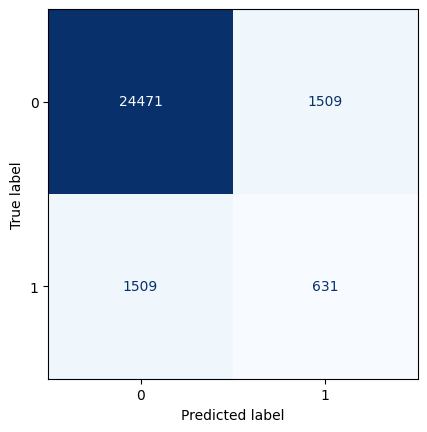

In [ ]:
### Performance metrics
accuracy = accuracy_score(testdf_results["WIN"], testdf_results["WIN_pred"])
print("Accuracy:", accuracy.round(3))
precision = precision_score(testdf_results["WIN"], testdf_results["WIN_pred"])
print("Precision:", precision.round(3))
recall = recall_score(testdf_results["WIN"], testdf_results["WIN_pred"])
print("Recall:", recall.round(3))

# Log loss score
def logloss(true_labels, predicted_probs, eps=1e-15):
  p = np.clip(predicted_probs, eps, 1 - eps)
  loss = -np.log(p) * true_labels - np.log(1 - p) * (1 - true_labels)
  return np.mean(loss)

logloss_score = logloss(true_labels=testdf_results["WIN"], predicted_probs=testdf_results["winprobability"])
print("Log loss score: ",logloss_score.round(4))

# Confusion matrix
cm = confusion_matrix(testdf_results["WIN"], testdf_results["WIN_pred"])
ConfusionMatrixDisplay(confusion_matrix=cm).plot(colorbar=False, cmap='Blues');

In [ ]:
# Feature importance
feature_importances = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances = feature_importances.to_frame().reset_index().rename(columns={"index":"feature",0:"importance"})
print(feature_importances.head(5))

fig = px.histogram(feature_importances, x="feature", y="importance")
fig.update_xaxes(tickangle=45)
fig.show()

                       feature  importance
0       jockey_AvgScore_scaled    0.081307
1  horse_AvgScore_Last5_scaled    0.079055
2    composite_past_perf_score    0.074149
3       jockey_totalprizemoney    0.048583
4               trainer_NbWins    0.048146


# 9. Winprobability output for test set

In [ ]:
testdf_results = testdf_results.rename(columns = {"WIN_pred":"win_classprediction", "WIN":"win_groundtruth"})
output = testdf_results[['RaceID','HorseID','winprobability','win_classprediction','win_groundtruth']]
print(output)
output.to_csv('predictions.csv',index=False)

        RaceID  HorseID  winprobability  win_classprediction  win_groundtruth
0      1680355  1563852        0.266487                    1                1
1      1680355  1563555        0.027493                    0                0
2      1680355  1563710        0.102366                    0                0
3      1680355  1561847        0.107848                    0                0
4      1680355  1564734        0.141075                    0                0
...        ...      ...             ...                  ...              ...
28115  1710893  1555238        0.095857                    0                0
28116  1710893  1557680        0.019998                    0                0
28117  1710893  1558434        0.042483                    0                0
28118  1710893  1558455        0.014386                    0                0
28119  1710893  1558875        0.231630                    1                0

[28120 rows x 5 columns]
